# Automated Change Monitoring with Sentinel-2 L2A

## 03 - Conduct Change Analysis

#### Connect to the ArcGIS Online organization

In [ ]:
from arcgis import GIS
from arcgis.features import FeatureLayerCollection
from arcgis.raster.analytics import copy_raster
import getpass

org_url = input('Enter ArcGIS Enterprise Portal URL (e.g. https://cname.domain/portal): ')
uname = input('Enter username: ')
pw = getpass.getpass('Enter password: ')
gis = GIS(org_url, uname, pw, verify_cert=False)

#### Load the Monitoring specification Feature Service

In [ ]:
monitoring_aois_guid = input('Enter the GUID for your Sentinel-2 L2A Monitoring Controls Feature Service: ')
monitoring_aois_item = gis.content.get(monitoring_aois_guid)
monitoring_aois_item

#### Access the layer and query it for the active AOIs

In [ ]:
monitoring_aois_layers = monitoring_aois_item.layers
monitoring_aois_layer = monitoring_aois_layers[0]

active_aois = monitoring_aois_layer.query(where="Active='True'",
                                          out_fields='name,description,active,startdate,enddate,lastmoddate,cloudcoverpct,notify,contactemail,imageservice,changeimageservice')
active_aois.sdf

## Select last and previous image sets

#### Create a raster collection to represent the mosaic dataset for each AOI

In [ ]:
from arcgis.raster import RasterCollection
from os.path import join, abspath, dirname, exists

# We assume there is only one AOI set to active for this demo
for feature in active_aois:
    gdb_name = feature.attributes["name"]
    base_path = f"C:\data\Sentinel-2-l2a\change_monitor\{gdb_name}.gdb"
    full_path = join(base_path, gdb_name) 
    rc = RasterCollection(full_path)
    #service_url = gis.content.search('Blythe')[0].url
    #rc = RasterCollection(service_url, gis=gis)
    print(rc)

#### Sort all acquisition dates in ascending order

In [5]:
from datetime import date 

# Convert string dates to date objects, so they can be sorted
all_date_strs = rc.get_field_values('DayDate')
all_dates = []
for dt in all_date_strs:
    date_parts = dt.split('/')
    yr = int(date_parts[2])
    mon = int(date_parts[0])
    day = int(date_parts[1])
    dt = date(yr, mon, day)
    all_dates.append(dt)
    
# Sort the dates in ascending order
all_uniq_dates = set(all_dates)
all_uniq_dates_sorted = sorted(all_uniq_dates)
print("All acquisition dates, sorted in ascending order:")
print("\n".join([d.strftime('%Y-%m-%d') for d in all_uniq_dates_sorted]))

All acquisition dates, sorted in ascending order:
2022-06-02
2022-06-07
2022-06-10
2022-06-12
2022-06-15
2022-06-17
2022-06-20
2022-06-22
2022-06-25
2022-06-27
2022-06-30
2022-07-02
2022-07-05
2022-07-07


#### Identify all recent dates needed to cover the AOI

In [6]:
from arcgis.geometry import intersect
from arcgis.geometry import Geometry, project

def dates_to_cover(rastcoll, sorted_dates, start_index, ok_cover_frac=0.9):
    last_index = start_index
    not_covered = True
    covered_geom = None
    aoi_geom = Geometry(feature.geometry)
    while (not_covered):
        last_dt = all_uniq_dates_sorted[last_index]
        last_dt_str = last_dt.strftime('%Y-%m-%dT%H:%M:%S')
        last_items = rastcoll.filter_by_time(last_dt_str, last_dt_str, 'DayDate')
        for item in last_items:
            geom = Geometry(item['Shape'])
            if not covered_geom:
                covered_geom = geom
            else:
                covered_geom = covered_geom.union(geom)
        sr = aoi_geom.spatial_reference
        intersect_geoms = intersect(sr, [covered_geom], aoi_geom, gis=gis, future=False)
        intersect_geom = intersect_geoms[0]
        if (intersect_geom.area >= ok_cover_frac * aoi_geom.area):
            not_covered = False
        last_index += -1
    end_index = last_index + 1
    return end_index

# Identify all dates for last date
start_last_index = len(all_uniq_dates_sorted) - 1
ok_cover_frac = 0.9   # We will consider it covered if it's 90% or greater
end_last_index = dates_to_cover(rc, all_uniq_dates_sorted, start_last_index, ok_cover_frac)
print("LAST MOSAIC DATES:")
for i in range(end_last_index, start_last_index + 1):
    print("  * " + all_uniq_dates_sorted[i].strftime('%Y-%m-%d'))

# Identify all dates for previous date
start_prev_index = end_last_index - 1
end_prev_index = dates_to_cover(rc, all_uniq_dates_sorted, start_prev_index, ok_cover_frac)
print("PREV MOSAIC DATES:")
for i in range(end_prev_index, start_prev_index + 1):
    print("  * " + all_uniq_dates_sorted[i].strftime('%Y-%m-%d'))

LAST MOSAIC DATES:
  * 2022-07-05
  * 2022-07-07
PREV MOSAIC DATES:
  * 2022-06-30
  * 2022-07-02


#### Make last dates mosaic

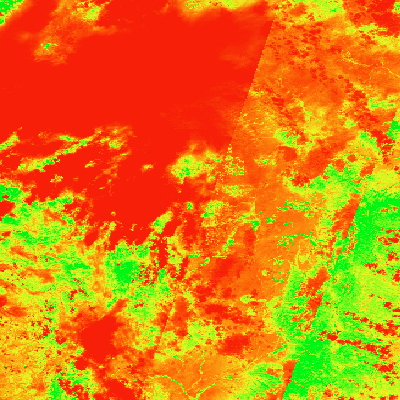

In [7]:
from arcgis.raster.functions import ndvi, stretch, reproject

#reproject(rc, spatial_reference={"wkid" : 3857, "latestWkid" : 3857})

last_items = rc.filter_by_time(all_uniq_dates_sorted[end_last_index].strftime('%Y-%m-%dT%H:%M:%S'), 
                               all_uniq_dates_sorted[start_last_index].strftime('%Y-%m-%dT%H:%M:%S'), 
                               'DayDate')
last_mosaic = last_items.mosaic('mean')
last_mosaic_ndvi = ndvi(last_mosaic, band_indexes=[8,4], astype="F32")

# This will mimic a fixed stretch from 0.0 to 0.6, which includes the vast majority of NDVI values
stats = [[0.0, 0.6, 0.25, 0.25]] 
last_mosaic_ndvi_str = stretch(last_mosaic_ndvi, 'PercentClip', min_percent=0.0, max_percent=0.0, dra=False, colorramp='Red To Green', statistics=stats)

#reproject(last_mosaic_ndvi_str, spatial_reference={"wkid" : 102100, "latestWkid" : 102100})
last_mosaic_ndvi_str

#### Make previous dates mosaic

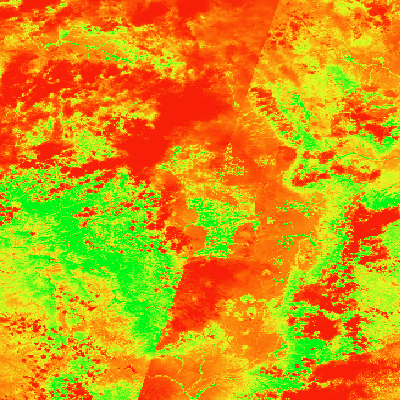

In [8]:
prev_items = rc.filter_by_time(all_uniq_dates_sorted[end_prev_index].strftime('%Y-%m-%dT%H:%M:%S'), 
                               all_uniq_dates_sorted[start_prev_index].strftime('%Y-%m-%dT%H:%M:%S'), 
                               'DayDate')
prev_mosaic = prev_items.mosaic('mean')
prev_mosaic_ndvi = ndvi(prev_mosaic, band_indexes=[8,4], astype="F32")

# Apply same fixed stretch, so we are viewing apples to apples
prev_mosaic_ndvi_str = stretch(prev_mosaic_ndvi, 'PercentClip', min_percent=0.0, max_percent=0.0, dra=False, colorramp='Red To Green', statistics=stats)
prev_mosaic_ndvi_str

#### Difference the two

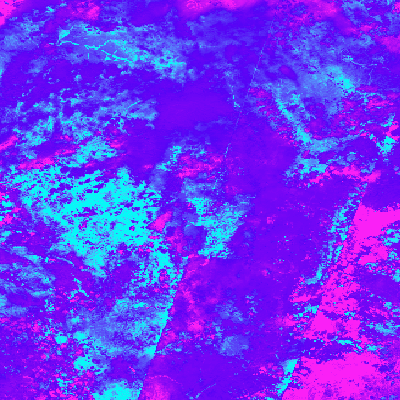

In [9]:
from arcgis.raster.functions import arithmetic

diff_ndvi = arithmetic(last_mosaic_ndvi, prev_mosaic_ndvi, 'IntersectionOf', 'MeanOf', 'F32', 2)

# Stretch using DRA this time, just to get maximum cont
diff_ndvi_str = stretch(diff_ndvi, 'StdDev', num_stddev=2.0, dra=True, colorramp='Cyan To Purple')
diff_ndvi_str